<a href="https://colab.research.google.com/github/hyunjaec/MScA_Machine_Learning_Project/blob/main/medical_deepfakes_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np 
import os 
import seaborn as sns
try:
  import pydicom
except:
  ! pip install pydicom
  import pydicom
import scipy.ndimage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.9 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
def load_dicom(path2scan_dir):
    dicom_folder = path2scan_dir
    dcms = os.listdir(dicom_folder)
    first_slice_data = pydicom.read_file(os.path.join(path2scan_dir,dcms[0]))
    first_slice = first_slice_data.pixel_array
    orientation = np.transpose(first_slice_data.ImageOrientationPatient) #zyx format
    spacing_xy = np.array(first_slice_data.PixelSpacing, dtype=float)
    spacing_z = np.float(first_slice_data.SliceThickness)
    spacing = np.array([spacing_z, spacing_xy[1], spacing_xy[0]]) #zyx format

    scan = np.zeros((len(dcms),first_slice.shape[0],first_slice.shape[1]))
    raw_slices=[]
    indexes = []
    for dcm in dcms:
        slice_data = pydicom.read_file(os.path.join(dicom_folder,dcm))
        slice_data.filename = dcm
        raw_slices.append(slice_data)
        indexes.append(float(slice_data.ImagePositionPatient[2]))
    indexes = np.array(indexes,dtype=float)

    raw_slices = [x for _, x in sorted(zip(indexes, raw_slices))]
    origin = np.array(raw_slices[0][0x00200032].value) #origin is assumed to be the image location of the first slice
    if origin is None:
        origin = np.zeros(3)
    else:
        origin = np.array([origin[2],origin[1],origin[0]]) #change from x,y,z to z,y,x

    for i, slice in enumerate(raw_slices):
        scan[i, :, :] = slice.pixel_array
    return scan, spacing, orientation, origin, raw_slices

In [40]:
df = pd.read_csv('/content/drive/My Drive/data/Tampered Scans/labels_exp1.csv')  


Load the label files and cut and save images by coordinates


In [41]:
def cutCube(X, center, shape, padd=0): #center is a 3d coord (zyx)
    center = center.astype(int)
    hlz = np.round(shape[0] / 2)
    hly = np.round(shape[1] / 2)
    hlx = np.round(shape[2] / 2)

    #add padding if out of bounds
    if ((center - np.array([hlz,hly,hlx])) < 0).any() or (
        (center + np.array([hlz,hly,hlx]) + 1) > np.array(X.shape)).any():  # if cropping is out of bounds, add padding
        try:
          np.ones(np.array(X.shape) + shape * 2)
        except:
          return "No"
        Xn = np.ones(np.array(X.shape) + shape * 2) * padd
        Xn[shape[0]:(shape[0] + X.shape[0]), shape[1]:(shape[1] + X.shape[1]), shape[2]:(shape[2] + X.shape[2])] = X
        centern = center + shape
        cube = Xn[int(centern[0] - hlz):int(centern[0] - hlz + shape[0]),
               int(centern[1] - hly):int(centern[1] - hly + shape[1]),
               int(centern[2] - hlx):int(centern[2] - hlx + shape[2])]
        return np.copy(cube)
    else:
        cube = X[int(center[0] - hlz):int(center[0] - hlz + shape[0]), int(center[1] - hly):int(center[1] - hly + shape[1]),
               int(center[2] - hlx):int(center[2] - hlx + shape[2])]
        return np.copy(cube)


In [42]:
import os
dir = "/content/drive/My Drive/data/Tampered Scans/Experiment 1 - Blind/" 
r=[]
for root, dirs, files in os.walk(dir):
  r.append(root)

In [44]:
#Load label files
label_df1 = pd.read_csv('/content/drive/My Drive/data/Results/Response EXP1 - Reviewer 1_instances.csv') 
label_df2 = pd.read_csv('/content/drive/My Drive/data/Results/Response EXP1 - Reviewer 2_instances.csv')
label_df3 = pd.read_csv('/content/drive/My Drive/data/Results/Response EXP1 - Reviewer 3_instances.csv')

preds = pd.concat([label_df1[['label']], label_df2[['label']], label_df3[['label']]], axis = 1)
preds.columns = ['label1','label2','label3']

def final_label(row):
  row.label1 = int(row.label1)
  row.label2 = int(row.label2)
  row.label3 = int(row.label3)
  if row.label1 == 0:
        row.label1 == -1
  if row.label2 == 0:
        row.label2 == -1
  if row.label3 == 0:
        row.label3 == -1
  if row.label1 == row.label2 == row.label3:
    return bool(row.label1)
  else:
    return bool(np.sign((row.label1*row.confidence1 + row.label1*row.confidence2 + row.label1*row.confidence3) / 3))

preds['label'] = preds.apply(lambda row: final_label(row), axis = 1)
label_df = pd.concat([label_df1.drop('label', axis = 1), preds['label']], axis = 1)
label_df.head()

,type,uuid,slice,x,y,detected,detected_diam,label
0,FB,1280,100,323,381,False,0.0,True
1,FB,1009,76,354,288,False,0.0,True
2,FB,7794,79,163,191,False,0.0,True
3,FB,7794,94,338,243,False,0.0,True
4,FB,2997,45,156,135,False,0.0,True


In [11]:
#label_df = pd.read_csv('/content/drive/My Drive/data/Results/Response EXP1 - AI_instances.csv')
#df_true = label_df.loc[label_df['label']==True]
#df_false = label_df.loc[label_df['label']==False]

In [45]:
df_true = label_df.loc[label_df['label']==True]
df_false = label_df.loc[label_df['label']==False]

In [47]:
df_true = df_true.reset_index()
df_false = df_false.reset_index()

In [48]:
def image_cut_processing(df):
  cut_cubes = []
  for i in range(0,len(df)):
    scan, spacing, orientation, origin, raw_slices = load_dicom('/content/drive/My Drive/data/Tampered Scans/Experiment 1 - Blind/'+str(df.uuid[i]))
    uuid_row = df.loc[df['uuid'] == df.uuid[i]]
    for j in range(len(uuid_row)):
      location = uuid_row.iloc[j]
      coord = np.array([location['slice'],location['y'],location['x']])
      if (cutCube(scan,coord,(64,64,64))) != "No":
        cut_cubes.append(cutCube(scan,coord,(64,64,64)))
  return cut_cubes
  

In [49]:
true_cut_images = image_cut_processing(df_true)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


In [50]:
false_cut_images = image_cut_processing(df_false)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


In [55]:
list1 = [True for i in range(len(true_cut_images))]
list2 = [False for i in range(len(false_cut_images))]
y = list1+list2
y = np.array(y)

In [56]:
X = true_cut_images + false_cut_images
y = pd.get_dummies(y)

In [57]:
len(X), len(y)

(260, 260)

In [60]:
y['label'] = (y[True] == 1).astype(int)

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y['label'], test_size=.2)

In [62]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [63]:
len(y_train)

208

In [64]:
X_test[8].shape, y_train[8].shape

((64, 64, 64), ())

In [65]:
X_train.shape

(208, 64, 64, 64)

In [66]:
# Training the model with best hyperparamters
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
classifier = Sequential()
classifier.add(Flatten(input_shape=[64, 64, 64]))
classifier.add(Dense(units=10, input_dim=9, kernel_initializer='uniform', activation='relu'))
classifier.add(Dense(units=10, kernel_initializer='uniform', activation='relu'))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 262144)            0         
                                                                 
 dense_3 (Dense)             (None, 10)                2621450   
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,621,571
Trainable params: 2,621,571
Non-trainable params: 0
_________________________________________________________________


In [67]:
history = classifier.fit(X_train, y_train,
          batch_size=20, epochs=40,
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/40
11/11 [==============================] - 2s 64ms/step - loss: 67.4794 - accuracy: 0.5144 - val_loss: 37.3443 - val_accuracy: 0.9038
Epoch 2/40
11/11 [==============================] - 0s 43ms/step - loss: 68.6261 - accuracy: 0.7452 - val_loss: 9.9405 - val_accuracy: 0.5769
Epoch 3/40
11/11 [==============================] - 0s 43ms/step - loss: 12.8109 - accuracy: 0.7452 - val_loss: 5.9742 - val_accuracy: 0.9038
Epoch 4/40
11/11 [==============================] - 0s 43ms/step - loss: 7.1031 - accuracy: 0.8173 - val_loss: 1.6551 - val_accuracy: 0.8846
Epoch 5/40
11/11 [==============================] - 0s 44ms/step - loss: 2.0224 - accuracy: 0.8654 - val_loss: 1.0379 - val_accuracy: 0.9038
Epoch 6/40
11/11 [==============================] - 0s 44ms/step - loss: 0.9486 - accuracy: 0.9135 - val_loss: 3.6748 - val_accuracy: 0.7500
Epoch 7/40
11/11 [==============================] - 0s 44ms/step - loss: 1.1078 - accuracy: 0.8798 - val_loss: 0.3097 - val_accuracy: 0.9423
Epoch 8/4

Evaluate the model


In [68]:
classifier.evaluate(X_test, y_test, verbose=1)


2/2 [==============================] - 0s 18ms/step - loss: 0.0722 - accuracy: 0.9615


[0.07216531783342361, 0.9615384340286255]

Text(0.5, 1.0, 'Loss Curves')

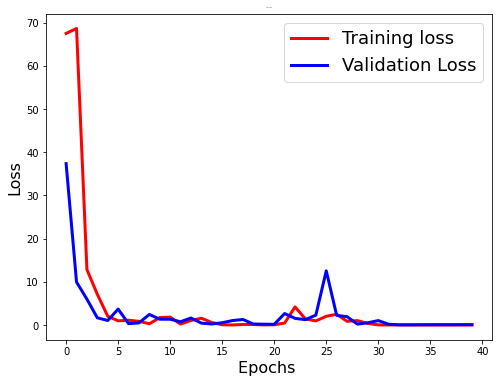

In [69]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=1)

In [33]:
#finished

In [71]:
y_pred = classifier.predict(X_test)
ypred1= np.round_(y_pred, decimals = 0, out = None).reshape(52,)
ypred1

array([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)

In [72]:
y_test

array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [74]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, ypred1)

In [75]:
cm

array([[ 3,  2],
       [ 0, 47]])